# Feature Selection for log_diff_model (Multivariate Model)

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from bdi_predict.ml_logic.sequence_gen import WindowGenerator
from tensorflow.keras import layers
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
bdi = pd.read_csv("../raw_data/data/BDI/log_diff_BDI_daily.csv")
bdi.head(2)

,Unnamed: 0,Date,Price,abs_price,log_price,log_diff
0,0,1995-01-03,1964.0,NaN,3.293141,NaN
1,1,1995-01-04,1961.0,-3.0,3.292478,-0.000664


In [3]:
bdi["Date"] = pd.to_datetime(bdi["Date"])
bdi.set_index("Date", inplace=True)
bdi= bdi[bdi.index != "1995-01-03"]
bdi.drop(columns="Unnamed: 0", inplace=True)
bdi.head(2)

,Price,abs_price,log_price,log_diff
Date,,,,
1995-01-04,1961.0,-3.0,3.292478,-0.000664
1995-01-05,1967.0,6.0,3.293804,0.001327


In [13]:
merged = pd.read_csv("../raw_data/data/merged_daily_data.csv")
merged["Date"] = pd.to_datetime(merged["Date"])
merged.set_index("Date", inplace=True)
cip = merged[["CIP"]]

In [130]:
feat = pd.read_csv("../raw_data/data/merged_features.csv")
feat["Date"] = pd.to_datetime(feat["Date"])
feat.set_index("Date", inplace=True)
feat.drop(columns="Unnamed: 0", inplace=True)
feat = feat[["close_y", "Nickel_x", "DAP"]]
feat.rename(columns={"close_y":"iron", 
                    "Nickel_x":"nickel", 
                    "DAP":"DAP"}, inplace=True)
comb=feat
comb

,iron,nickel,DAP
Date,,,
1995-01-03,12.270000,8505.450000,198.630000
1995-01-04,12.270000,8505.450000,198.630000
1995-01-05,12.270000,8505.450000,198.630000
1995-01-06,12.270000,8505.450000,198.630000
1995-01-09,12.270000,8505.450000,198.630000
...,...,...,...
2022-11-08,27.540690,10264.567966,306.576271
2022-11-09,26.013621,10003.955424,297.296610
2022-11-10,24.486552,9743.342881,288.016949


In [204]:
cass = pd.read_csv("../raw_data/data/CASS/CASS FREIGHT INDEX.csv")
cass = cass[["time", "close"]]
cass["time"] = pd.to_datetime(cass["time"], origin="unix")
cass.set_index("time", inplace=True)
datetime_index = pd.date_range(start="1994-01-01", end="2021-12-01", name="Date")
len(datetime_index)
cass_df = pd.DataFrame(index=datetime_index)
cass_df["cass"] = cass["close"]
cass_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10197 entries, 1994-01-01 to 2021-12-01
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cass    0 non-null      float64
dtypes: float64(1)
memory usage: 159.3 KB


In [168]:
df = pd.merge(bdi, cip, on="Date", how="inner")
#df.drop(columns="Price_y", inplace=True)


In [169]:
df.head(3)

,Price,abs_price,log_price,log_diff,CIP
Date,,,,,
1995-01-04,1961.0,-3.0,3.292478,-0.000664,11.988118
1995-01-05,1967.0,6.0,3.293804,0.001327,12.173925
1995-01-06,1983.0,16.0,3.297323,0.003518,12.354720


In [170]:
len(df)

7065

# Data Cleaning

## Holdout Method (manual, chronological)

In [171]:
input_length = len(df)

In [172]:
def train_test_split(df:pd.DataFrame,
                     train_test_ratio: float,
                     input_length: int) -> tuple:
    '''
    Returns a train dataframe and a test dataframe (df_train, df_test)
    from which one can sample (X,y) sequences using TimeseriesGenerator.
    df_train should contain all the timesteps until round(train_test_ratio * len(fold))   
    '''
    
    # TRAIN SET

    last_train_idx = round(train_test_ratio * len(df))
    df_train = df.iloc[0:last_train_idx, :]

    # TEST SET
 
    first_test_idx = last_train_idx - input_length
    df_test = df.iloc[first_test_idx:, :]

    return (df_train, df_test)

In [173]:
df_train, df_test = train_test_split(df=df, train_test_ratio=0.8, input_length=input_length)

In [174]:
X_train = df_train[["Price", "CIP"]]
y_train = df_train["log_diff"]

X_test  = df_test[["Price", "CIP"]]
y_test = df_test["log_diff"]

In [175]:
#Feature Scaling

scaler_X = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.fit_transform(X_test)



In [176]:
generator = TimeseriesGenerator(X_train_scaled, y_train, length=20, batch_size=8, sampling_rate=1, stride=1)

In [177]:
len(generator)

704

In [178]:
generator_val = TimeseriesGenerator(X_test_scaled, y_test, length=20, batch_size=8, sampling_rate=1, stride=1)

In [179]:
for X, y in generator:
    print(X.shape, y.shape)
    print(X[0], y[0])
    #listy = [float(X[0][i]) for i in range(len(X[0]))]
    #print(listy)
    break

(8, 20, 2) (8,)
[[0.14519214 0.39141632]
 [0.14571379 0.39855159]
 [0.14710485 0.40549438]
 [0.14806121 0.42519177]
 [0.14988698 0.43138855]
 [0.15023474 0.43740479]
 [0.15188663 0.4432429 ]
 [0.15379934 0.44890526]
 [0.15440793 0.46486177]
 [0.15475569 0.46984505]
 [0.15475569 0.47466453]
 [0.15466875 0.47932262]
 [0.1537124  0.48382169]
 [0.15240828 0.49638873]
 [0.15136498 0.50027566]
 [0.1501478  0.50401553]
 [0.14823509 0.50761073]
 [0.14710485 0.51106366]
 [0.1465832  0.52059267]
 [0.14623544 0.52350039]] -0.0015435717560743


# The Model

In [180]:
# Learning Rate Scheduler: 

lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)

In [207]:
#Optimizers

rmsprop = RMSprop(learning_rate=lr_schedule) #or 0.001 for inital test
adam = Adam(learning_rate=lr_schedule)

In [ ]:
#Early Stopping Criterion:

es = EarlyStopping(monitor="val_loss", patience=500, restore_best_weights=True)

In [209]:
#Initializing and compiling model:

def init_model():
    
    
    model = Sequential()

    #LSTM layers
    model.add(layers.LSTM(50, activation="tanh", input_shape=(20,2), return_sequences=False))

    #Dense layers
    model.add(layers.Dense(80, activation="relu"))
    model.add(layers.Dense(1, activation="linear"))

    #compiling model
    model.compile(loss="mse", optimizer=rmsprop, metrics="mae")
    
    return model

# Training and Testing

In [210]:
#Instantiating model

model = init_model()

In [211]:
#Model layers & params overview:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 50)                10600     
                                                                 
 dense_24 (Dense)            (None, 80)                4080      
                                                                 
 dense_25 (Dense)            (None, 1)                 81        
                                                                 
Total params: 14,761
Trainable params: 14,761
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#TRAINING THE MODEL:

history = model.fit(
    generator, epochs=1000, validation_data=generator_val, shuffle=True, callbacks=es
)

Epoch 1/1000
704/704 [==============================] - 4s 4ms/step - loss: 1.4887e-04 - mae: 0.0084 - val_loss: 1.7657e-04 - val_mae: 0.0101
Epoch 2/1000
704/704 [==============================] - 3s 4ms/step - loss: 7.9145e-05 - mae: 0.0064 - val_loss: 1.2914e-04 - val_mae: 0.0086
Epoch 3/1000
704/704 [==============================] - 3s 4ms/step - loss: 6.7120e-05 - mae: 0.0058 - val_loss: 1.0678e-04 - val_mae: 0.0078
Epoch 4/1000
704/704 [==============================] - 3s 4ms/step - loss: 6.5498e-05 - mae: 0.0057 - val_loss: 1.3908e-04 - val_mae: 0.0093
Epoch 5/1000
704/704 [==============================] - 3s 4ms/step - loss: 6.1298e-05 - mae: 0.0055 - val_loss: 1.0350e-04 - val_mae: 0.0076
Epoch 6/1000
704/704 [==============================] - 3s 4ms/step - loss: 6.0886e-05 - mae: 0.0054 - val_loss: 1.0207e-04 - val_mae: 0.0076
Epoch 7/1000
704/704 [==============================] - 3s 4ms/step - loss: 5.9403e-05 - mae: 0.0053 - val_loss: 1.0703e-04 - val_mae: 0.0079
Epoch 

704/704 [==============================] - 3s 4ms/step - loss: 2.6400e-05 - mae: 0.0035 - val_loss: 3.8151e-05 - val_mae: 0.0043
Epoch 59/1000
704/704 [==============================] - 3s 4ms/step - loss: 2.5639e-05 - mae: 0.0034 - val_loss: 3.5396e-05 - val_mae: 0.0037
Epoch 60/1000
704/704 [==============================] - 3s 4ms/step - loss: 2.5436e-05 - mae: 0.0034 - val_loss: 3.0882e-05 - val_mae: 0.0032
Epoch 61/1000
704/704 [==============================] - 3s 4ms/step - loss: 2.4760e-05 - mae: 0.0033 - val_loss: 3.1725e-05 - val_mae: 0.0033
Epoch 62/1000
704/704 [==============================] - 3s 4ms/step - loss: 2.4726e-05 - mae: 0.0033 - val_loss: 3.5138e-05 - val_mae: 0.0035
Epoch 63/1000
704/704 [==============================] - 3s 4ms/step - loss: 2.4288e-05 - mae: 0.0033 - val_loss: 3.5340e-05 - val_mae: 0.0036
Epoch 64/1000
704/704 [==============================] - 3s 4ms/step - loss: 2.4385e-05 - mae: 0.0033 - val_loss: 3.4183e-05 - val_mae: 0.0034
Epoch 65/1000

704/704 [==============================] - 3s 4ms/step - loss: 1.9632e-05 - mae: 0.0028 - val_loss: 3.7475e-05 - val_mae: 0.0042
Epoch 116/1000
704/704 [==============================] - 3s 4ms/step - loss: 1.9821e-05 - mae: 0.0028 - val_loss: 3.1261e-05 - val_mae: 0.0033
Epoch 117/1000
704/704 [==============================] - 3s 4ms/step - loss: 1.9596e-05 - mae: 0.0028 - val_loss: 3.7155e-05 - val_mae: 0.0041
Epoch 118/1000
704/704 [==============================] - 3s 4ms/step - loss: 1.9790e-05 - mae: 0.0028 - val_loss: 3.2534e-05 - val_mae: 0.0033
Epoch 119/1000
704/704 [==============================] - 3s 4ms/step - loss: 1.9770e-05 - mae: 0.0028 - val_loss: 3.5243e-05 - val_mae: 0.0038
Epoch 120/1000
704/704 [==============================] - 3s 4ms/step - loss: 1.9611e-05 - mae: 0.0028 - val_loss: 3.2663e-05 - val_mae: 0.0035
Epoch 121/1000
704/704 [==============================] - 3s 4ms/step - loss: 1.9871e-05 - mae: 0.0029 - val_loss: 3.4879e-05 - val_mae: 0.0035
Epoch 1

Epoch 172/1000
704/704 [==============================] - 3s 4ms/step - loss: 1.8546e-05 - mae: 0.0027 - val_loss: 3.4107e-05 - val_mae: 0.0038
Epoch 173/1000
704/704 [==============================] - 3s 4ms/step - loss: 1.8671e-05 - mae: 0.0027 - val_loss: 3.3659e-05 - val_mae: 0.0033
Epoch 174/1000
704/704 [==============================] - 3s 4ms/step - loss: 1.8673e-05 - mae: 0.0027 - val_loss: 3.3500e-05 - val_mae: 0.0034
Epoch 175/1000
704/704 [==============================] - 3s 4ms/step - loss: 1.8409e-05 - mae: 0.0027 - val_loss: 3.3557e-05 - val_mae: 0.0035
Epoch 176/1000
704/704 [==============================] - 3s 4ms/step - loss: 1.8507e-05 - mae: 0.0027 - val_loss: 3.4221e-05 - val_mae: 0.0035
Epoch 177/1000
704/704 [==============================] - 3s 4ms/step - loss: 1.9009e-05 - mae: 0.0027 - val_loss: 3.6367e-05 - val_mae: 0.0038
Epoch 178/1000
704/704 [==============================] - 3s 4ms/step - loss: 1.8600e-05 - mae: 0.0027 - val_loss: 3.5016e-05 - val_mae:

Epoch 229/1000
704/704 [==============================] - 3s 4ms/step - loss: 1.7993e-05 - mae: 0.0026 - val_loss: 4.1144e-05 - val_mae: 0.0041
Epoch 230/1000
704/704 [==============================] - 3s 4ms/step - loss: 1.7996e-05 - mae: 0.0026 - val_loss: 4.0512e-05 - val_mae: 0.0038
Epoch 231/1000
704/704 [==============================] - 3s 4ms/step - loss: 1.7746e-05 - mae: 0.0026 - val_loss: 3.9383e-05 - val_mae: 0.0038
Epoch 232/1000
704/704 [==============================] - 3s 4ms/step - loss: 1.7761e-05 - mae: 0.0026 - val_loss: 3.7475e-05 - val_mae: 0.0037
Epoch 233/1000
704/704 [==============================] - 3s 4ms/step - loss: 1.7734e-05 - mae: 0.0026 - val_loss: 3.9038e-05 - val_mae: 0.0038
Epoch 234/1000
704/704 [==============================] - 3s 4ms/step - loss: 1.7761e-05 - mae: 0.0026 - val_loss: 4.1980e-05 - val_mae: 0.0041
Epoch 235/1000
704/704 [==============================] - 3s 4ms/step - loss: 1.7952e-05 - mae: 0.0027 - val_loss: 4.0950e-05 - val_mae:

In [188]:
model.evaluate(generator_val)

175/175 [==============================] - 0s 971us/step - loss: 3.2146e-05 - mae: 0.0032


[3.2146333978744224e-05, 0.0032496480271220207]

In [ ]:
#model.save("cip_model_best")

array([<AxesSubplot: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <AxesSubplot: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

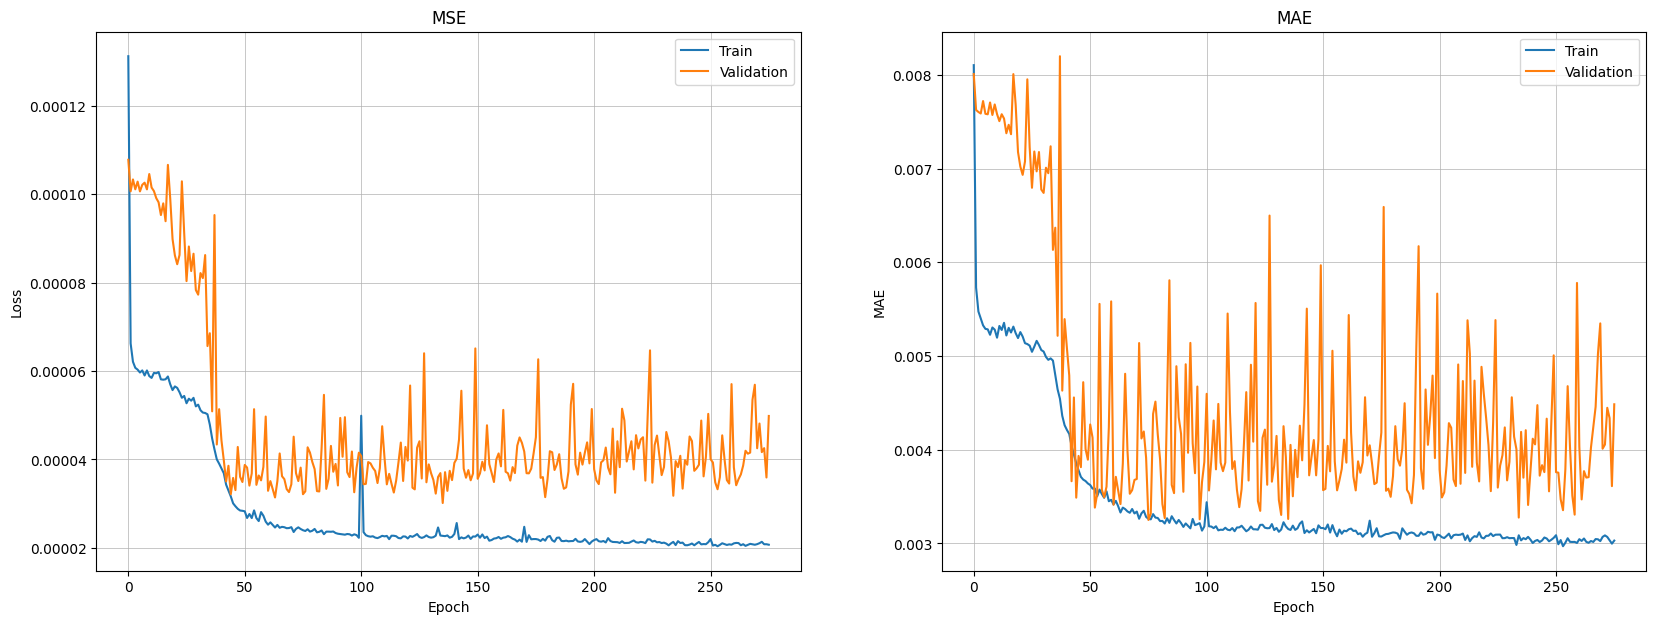

In [206]:
# Learning Curves:
plot_history(history)

In [ ]:
#Baseline MAE
0.0048812746058099115

# Learning Curves viz code:

In [205]:
def plot_history(history):
    
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # Loss:MSE
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # Metrics:MAE
    
    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
                        
    return ax